# Moonpool OWC
From paper:

> Brito-Melo, Ana, et al. "A 3D boundary element code for the analysis of OWC wave-power plants." ISOPE International Ocean and Polar Engineering Conference. ISOPE, 1999. 

Used as validation for implementation of OWC solver in Capytaine. 
The fixed OWC linear problem consists of two problems for every frequency: a radiation problem and a diffraction problem. 
The radiation problem is: volumetric flow rate in the chamber due to oscillating pressure fluctuation in the chamber. 
The diffraction problem is: volumetric flow rate in the chamber due to incoming wave with no pressure change (chamber open to atmosphere).

In [1]:
import numpy as np
import capytaine as cpt
from capytaine.bem.problems_and_results import OWCRadiationProblem, _default_parameters
g= _default_parameters['g']
from capytaine.io.meshio import load_from_meshio
import gmsh
import pygmsh
import matplotlib.pyplot as plt

## Mesh

In [2]:
name = "moonpool"
draft = 5 # m
side_length = 20 # m
wall_thickness = 0.5 # m

mesh_size_factor = 0.4
mesh_size_factor_lid = 0.4
freeboard = 1 # m
L = side_length / 2

In [3]:
with pygmsh.occ.Geometry() as geom:
    gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
    wall_s = geom.add_box([0, 0, -draft], [wall_thickness, side_length, draft+freeboard])
    wall_n = geom.add_box([side_length, 0, -draft], [-wall_thickness, side_length, draft+freeboard])
    wall_w = geom.add_box([0, side_length, -draft], [side_length, -wall_thickness, draft+freeboard])
    wall_e = geom.add_box([0, 0, -draft], [side_length, wall_thickness, draft+freeboard])
    geom.boolean_union([wall_s, wall_n, wall_e, wall_w])
    mesh = load_from_meshio(geom.generate_mesh())
    mesh = mesh.keep_immersed_part()

In [4]:
with pygmsh.occ.Geometry() as geom:
    gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor_lid)
    internal_surface = geom.add_rectangle([wall_thickness, wall_thickness, 0], side_length-2*wall_thickness, side_length-2*wall_thickness)
    mesh_lid = load_from_meshio(geom.generate_mesh())

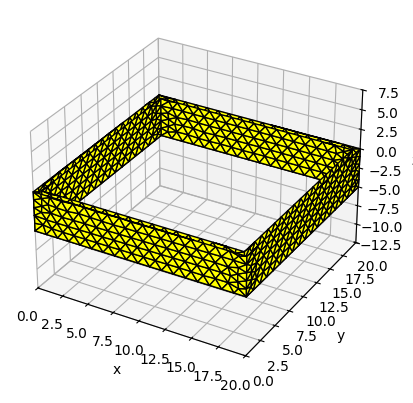

In [5]:
mesh.show_matplotlib()

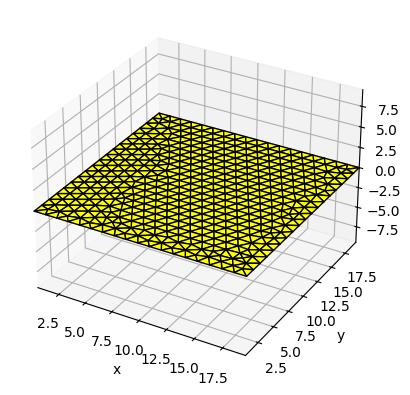

In [6]:
mesh_lid.show_matplotlib()

## BEM

In [7]:
# frequencies
d = 0.05
kl_f = 2
lwavenumber = np.linspace(d, kl_f-d, int(kl_f/d)-1)
wavenumber = lwavenumber / L
omega = np.sqrt(g*wavenumber)

In [8]:
fb = cpt.FloatingBody(name=name, mesh=mesh, lid_mesh=mesh_lid, dofs={})
solver = cpt.BEMSolver(method="direct")
results = []

for k in wavenumber:
    problem = OWCRadiationProblem(body=fb, wavenumber=k)
    results.append(solver.solve_owc(problem, keep_details=True))

[11:22:01] WARNING  Inverting the direction of the normal vectors of Mesh(vertices=[[... 423 vertices ...]],       
                    faces=[[... 772 faces ...]], name="mesh_from_meshio_6") to be downward.

## Result: B7

In [9]:
# integrate over lid
ab7 = []
for result in results:
    potential = result.potential
    face_areas = result.body.lid_mesh.faces_areas
    ab7.append(np.sum(potential * face_areas))

b7nd = np.imag(ab7)/L**3

In [10]:
b7_aquadyn_numerical = np.array([
    0.023931734124074358, 0.23231011200517904,
    0.09767692964714793, 0.8110934510791755,
    0.20047326280052322, 1.777184806470488,
    0.29717250993126676, 2.656875723634794,
    0.3975246367936311, 3.558726983744932,
    0.5079168110359943, 4.835187636686572,
    0.6016668949716499, 6.326777911034938,
    0.6698360770220435, 8.122512667499409,
    0.7255478648112187, 10.135991467852978,
    0.7896773916289963, 13.83552377672002,
    0.8550370794152169, 17.52883127015284,
    0.8903733189366897, 20.235256524644043,
    0.9231794020558193, 22.855405837216928,
    0.9494801361234888, 24.014590967377817,
    0.9833015049327306, 24.75534400405028,
    1.0257608599308639, 23.36210581356263,
    1.05764835123513, 21.836154558017355,
    1.0844916453805844, 19.299542268571738,
    1.1151543475983658, 16.193110374277403,
    1.133848496813131, 14.018657846794843,
    1.1735037294290496, 11.121006262164327,
    1.198751574632899, 9.211232886944902,
    1.2134759030805058, 7.963655377618053,
    1.2543988998385749, 6.19107693456889,
    1.3139247238181189, 4.447630627751887,
    1.355674990397761, 3.314714218723415,
    1.4215181475602254, 2.2315963331687216,
    1.5306909045980623, 1.3443111411746642,
    1.6205893491696413, 0.9645973996870992,
    1.7274253375556325, 0.7199621531221599,
    1.853363738185217, 0.46773263172746926,
    1.9753860368672258, 0.3690070589407024
]).reshape(-1,2)

b7_wamit = np.array([
    0.09887485932384121, 0.49686476795962997,
    0.19542906564171159, 1.153956285196144,
    0.29346591138006334, 1.9299417772263052,
    0.3887630973196995, 2.711529603147267,
    0.49072678876954356, 3.6069070552058133,
    0.5783206959810265, 4.8369305850081545,
    0.5783206959810265, 4.8369305850081545,
    0.6622617234608886, 6.386660635512157,
    0.6622617234608886, 6.386660635512157,
    0.7185859057933061, 8.066364832282723,
    0.7592295646895455, 9.678467533437633,
    0.7592295646895455, 9.678467533437633,
    0.8046971735843077, 11.730042204248644,
    0.8356445855458772, 13.792946039149939,
    0.8356445855458772, 13.792946039149939,
    0.8710076844771413, 15.607479738225761,
    0.8710076844771413, 15.607479738225761,
    0.9019819558485022, 18.622406845637027,
    0.9019819558485022, 18.622406845637027,
    0.9314843315632982, 20.61833166646609,
    0.9314843315632982, 20.61833166646609,
    0.951607401378962, 22.29454996659349,
    1.0002873956847673, 23.918977802308163,
    1.0616880064677459, 22.038461059629583,
    1.0872151895334252, 19.117155176349023,
    1.1165026899698907, 16.397284320519898,
    1.1487984443029848, 13.133240099431053,
    1.1794557746388081, 10.329458731548609,
    1.2336204604240026, 6.835843317245644,
    1.2965413138011705, 4.678695776670222,
    1.394696340942604, 2.7231077598549205,
    1.5046211614545981, 1.3419457113096596,
    1.668613973876538, 0.6179996763095974,
    1.8033730046815952, 0.3701275257188624
]).reshape(-1,2)

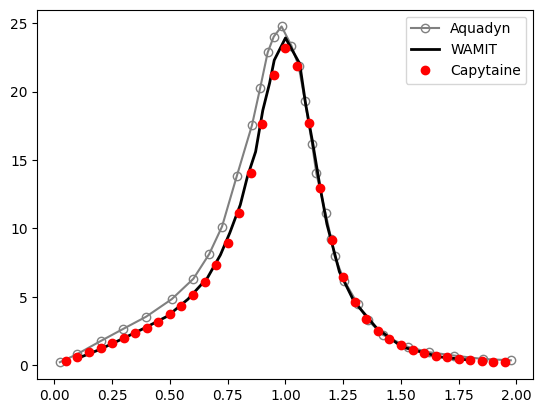

In [11]:
plt.plot(b7_aquadyn_numerical[:,0], b7_aquadyn_numerical[:,1], '-o', color="0.5", markerfacecolor='none', label="Aquadyn")
plt.plot(b7_wamit[:,0], b7_wamit[:,1], 'k-', linewidth=2, label="WAMIT")
plt.plot(lwavenumber, b7nd, 'ro', label="Capytaine")
plt.legend()

<img src="brito-melo_et_al.png" alt="Plot of normalized B7 using different methods from the paper by Brito-Melo et al, 1999" style="width: 600px;"/>


## Result: Radiation Admittance
The real and imaginary parts of the radiation admittance ($Y_r = G+iB$) are the coefficients needed for the linear OWC model.
The volumetric flow in the chamber due to pressure oscillation is given as $Q_r(\omega) = Y_r(\omega) P(\omega)$.
The paper does not show these coefficients for the moonpool, but it does show them for the Pico Plant OWC in the Azores; trends should be similar. 
One check: the conductance (real component) should always be positive. 

In [12]:
# integrate vertical. gradients over lid
G = np.array([result.conductance for result in results])
B = np.array([result.susceptance for result in results])


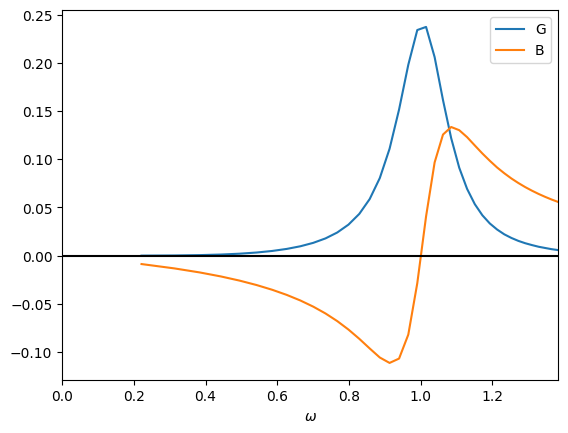

In [13]:
plt.plot(omega, G, label="G")
plt.plot(omega, B, label="B")
plt.hlines([0], 0, omega[-1], color="k")
plt.xlim([0, omega[-1]])
plt.xlabel("$\omega$")
plt.legend()

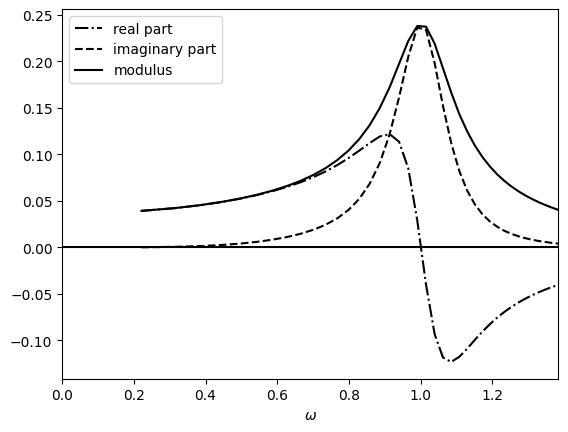

In [15]:
Hr = -(G+1j*B) / (1j * omega)
plt.plot(omega, np.real(Hr), 'k-.', label="real part")
plt.plot(omega, np.imag(Hr), 'k--', label="imaginary part")
plt.plot(omega, np.abs(Hr), 'k-', label="modulus")
plt.hlines([0], 0, omega[-1], color="k")
plt.xlim([0, omega[-1]])
plt.xlabel("$\omega$")
plt.legend()